In [1]:
import torch
from d2l import torch as d2l
torch.set_printoptions(2) # 精简打印精度

def multibox_prior(data, sizes, ratios):
    """⽣成以每个像素为中⼼具有不同形状的锚框。 """
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中⼼，需要设置偏移量。
    # 因为⼀个像素的的⾼为1且宽为1，我们选择偏移我们的中⼼0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # Scaled steps in y axis
    steps_w = 1.0 / in_width # Scaled steps in x axis

    # ⽣成锚框的所有中⼼点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # ⽣成“boxes_per_pixel”个⾼和宽，
    # 之后⽤于创建锚框的四⻆坐标 (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                    sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                    * in_height / in_width # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                    sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # 除以2来获得半⾼和半宽
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    
    # 每个中⼼点都将有“boxes_per_pixel”个锚框，
    # 所以⽣成含所有锚框中⼼的⽹格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                            dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [6]:
img = d2l.plt.imread('C:/Users/123/Desktop/dog.jpg')
h, w = img.shape[:2]
print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

490 490


torch.Size([1, 1200500, 4])

In [7]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.14, 0.14, 0.89, 0.89])

In [8]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显⽰所有边界框。 """
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
            ha='center', fontsize=9, color=text_color,
            bbox=dict(facecolor=color, lw=0))

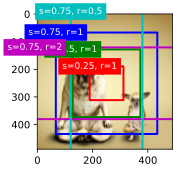

In [9]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale, [
's=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'
])

In [10]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并⽐。 """
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
    (boxes[:, 3] - boxes[:, 1]))
    # `boxes1`, `boxes2`, `areas1`, `areas2`的形状:
    # `boxes1`： (boxes1的数量, 4),
    # `boxes2`： (boxes2的数量, 4),
    # `areas1`： (boxes1的数量,),
    # `areas2`： (boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # `inter_upperlefts`, `inter_lowerrights`, `inters`的形状:
    # (boxes1的数量, boxes2的数量, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # `inter_areas` and `union_areas`的形状: (boxes1的数量, boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas